In [1]:
import pandas as pd
# coding: UTF-8
import time
import torch
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from torch.utils.data import SubsetRandomSampler
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from units import *

### 数据预处理

In [2]:
save='./统计指标2/6/'
rawdata=pd.read_excel("../backup/arousal_record.xlsx")
rawdata=rawdata[['aweme_id','collect_count','create_time','digg_count','duration','follower_count','gender','share_count','keyword','comment_get','comment_count','intention_counts','variation','arousal']]
rawdata=rawdata[rawdata['variation'].notna()]
rawdata=rawdata[rawdata['arousal'].notna()]
def keyword_encode(keyword):
    if "运动" in keyword:
        return 0
    elif "健身" in keyword:
        return 1
    elif "减肥" in keyword:
        return 2
    elif "自律" in keyword:
        return 3
rawdata['keyword']=rawdata['keyword'].apply(keyword_encode) # 非数字编码
rawdata.fillna(0) # 空值填充0
rawdata['intention_counts']=rawdata['intention_counts']/rawdata['comment_get']
rawdata.drop('comment_get',axis=1)
columns=['aweme_id','collect_count', 'create_time','duration',
       'follower_count', 'gender', 'share_count', 'keyword','comment_count',
        'variation', 'arousal' ,'V*A','digg_count', 'intention_counts']
rawdata['V*A']=rawdata['variation']*rawdata['arousal']
rawdata=rawdata[columns]
select_num=220
select_pd=pd.DataFrame()
select_pd=select_pd.append(rawdata.sort_values(by=['variation','arousal'],ascending=[False,False]).head(select_num),ignore_index=True)
select_pd=select_pd.append(rawdata.sort_values(by=['arousal','variation'],ascending=[False,False]).head(select_num),ignore_index=True)
select_pd=select_pd.append(rawdata.sort_values(by=['variation','arousal'],ascending=[True,False]).head(select_num),ignore_index=True)
select_pd=select_pd.append(rawdata.sort_values(by=['arousal','variation'],ascending=[True,False]).head(select_num),ignore_index=True)
rawdata=select_pd.drop_duplicates('aweme_id')
columns=['collect_count', 'create_time','duration',
       'follower_count', 'gender', 'share_count', 'keyword','comment_count',
        'variation',
         'arousal',
         'V*A',
         'digg_count', 'intention_counts']
rawdata=rawdata[columns]

### 数据归一化

In [3]:
scaler = MinMaxScaler() #实例化
rawdata = scaler.fit_transform(rawdata) #fit，在这里本质是生成min(x)和max(x)
rawdata = pd.DataFrame(rawdata,columns=columns)
rawdata=rawdata.fillna(0)

In [4]:
X,y=rawdata.iloc[:,:-2].values, rawdata.iloc[:,-1]

### 划分数据集

                            OLS Regression Results                            
Dep. Variable:       intention_counts   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.592
Date:                Sat, 11 Feb 2023   Prob (F-statistic):            0.00305
Time:                        14:46:26   Log-Likelihood:                 673.24
No. Observations:                 813   AIC:                            -1322.
Df Residuals:                     801   BIC:                            -1266.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1345      0.066      2.036      0.0

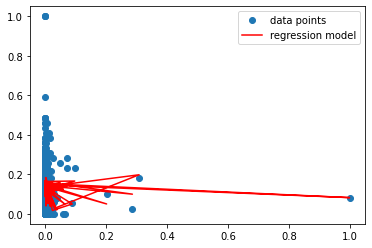

In [5]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 添加常数项，并计算回归模型
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# model.params.index = ['const'] + X_vars
# 打印回归模型的结果
path2 = save+'table.txt'
file2 = open(path2,'w+')
file2.write(str(model.summary()))
file2.close()
print(model.summary())

# 绘制回归模型
plt.plot(X[:, 1], y, 'o', label='data points')
plt.plot(X[:, 1], model.predict(X), 'r', label='regression model')
plt.legend()
plt.savefig(save+'regression.png')
plt.show()


In [7]:
rawdata.to_csv('detail_item.csv',index=False,encoding='utf_8_sig')